# Keras实战之验证码识别 (破解Captcha验证码)

每个人都讨厌 CAPTCHA——这些恼人的图片中包含你必须输入的文字，正确地填写它你才能访问网站。CAPTCHA 全称「全自动区分计算机和人类的公开图灵测试（Completely Automated Public Turing test to tell Computers and Humans Apart）」，旨在确认访问者是真正的人类，防止恶意程序的入侵。然而，随着深度学习和计算机视觉技术的发展，现在这些认证方法可以被我们轻松破解了。

**【知识点】**
- 了解使用Captcha生成在验证码图片
- 用Keras搭建神经网络来识别验证码

# 【目录】
- [1.生成验证码](#1.生成验证码)
- [2.构建深度神经网络](#2.构建深度神经网络)
- [3.预测](#3.预测)


# 1.生成验证码

In [1]:
# vocab.py
import random
import numpy as np
'''
    A default vocab implementation and base class, to provide random letters and numbers.
'''
class Vocab():
    def __init__(self):
        self.vocab = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.size = len(self.vocab)
        indices = range(self.size)
        self.index = dict(zip(self.vocab, indices))
    # return random string by given length
    def rand_string(self, length):
        # if len(vocab) == 0 raise exception
        return "".join(random.sample(self.vocab, length))
    # get symbol (char in vocabulary) by its ordinal
    def get_sym(self, idx):
        # if idx >= len(self.vocab) raise exception
        return self.vocab[idx]
    # given a symbol, return its ordinal in given vocabulary.
    def get_index(self, sym):
        return self.index[sym]
    # given 'abc', return [10, 11, 12]
    def to_indices(self, text):
        return [self.index[c] for c in text]
    # given [10, 11, 12], return 'abc'
    def to_text(self, indices):
        return "".join([self.vocab[i] for i in indices])
    # given '01', return vector [1 0 0 0 0 0 0 0 0 0 ... 0 \n 0 1 0 0 0 0 ... 0]
    def text_to_one_hot(self, text):
        num_labels = np.array(self.to_indices(text))
        n = len(text)
        categorical = np.zeros((n, self.size))
        categorical[np.arange(n), num_labels] = 1
        return categorical.ravel()
    # translate one hot vector to text.
    def one_hot_to_text(self, onehots):
        text_len = onehots.shape[0] // self.size
        onehots = np.reshape(onehots, (text_len, self.size))
        indices = np.argmax(onehots, axis = 1)
        return self.to_text(indices)
if __name__ == "__main__":
    # test code
    vocab = Vocab()
    print(vocab.rand_string(4))
    print(vocab.get_sym(10))
    print(vocab.get_index('a'))
    print(vocab.size)
    print(vocab.text_to_one_hot("abc"))

Zeo3
a
10
62
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


jODB


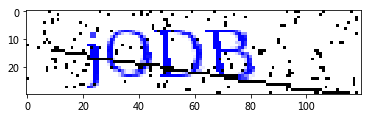

In [2]:
# PIL是一个常用的python图像库。在python 3.5中， 应该使用pip install pillow来安装
from PIL import Image, ImageFont, ImageDraw, ImageFilter
import random
# from vocab import Vocab

import matplotlib.pyplot as plt
%matplotlib inline

class Captcha(object):
    '''
    size: width, height in pixel
    font: font family(string), size (unit pound) and font color (in "#rrggbb" format)
    bgcolor: in "#rrggbb" format
    '''
    def __init__(self, size, font, bgcolor, length = 4):
        #todo: add param check and transform here
        self.width, self.height = size
        self.font_family, self.font_size, self.font_color = font
        self.bgcolor = bgcolor
        self.len = length
        self.vocab = Vocab()
        self.font = ImageFont.truetype(self.font_family, self.font_size)
    def get_text(self):
        return self.vocab.rand_string(self.len)
    # by default, draw center align text
    def draw_text(self, str):
        dr = ImageDraw.Draw(self.im)
        font_width, font_height = self.font.getsize(str)
        # don't know why, but for center align, I should divide it by 2, other than 3
        dr.text(((self.width - font_width) / 3, (self.height - font_height) / 3), str, fill = self.font_color, font = self.font)
    def draw_background(self):
        pass
    def transform(self):
        params = [1 - float(random.randint(1, 2)) / 100,
                  0,
                  0,
                  0,
                  1 - float(random.randint(1, 10)) / 100,
                  float(random.randint(1, 2)) / 500,
                  0.001,
                  float(random.randint(1, 2)) / 500
                  ]
        self.im = self.im.transform((self.width, self.height), Image.PERSPECTIVE, params)
    def filter(self):
        self.im.filter(ImageFilter.EDGE_ENHANCE_MORE)
    # by default, add no noises
    def add_noise(self):
        pass
    def get_captcha(self):
        self.im = Image.new("RGB", (self.width, self.height), (self.bgcolor))
        self.draw_background()
        str = self.get_text()
        self.draw_text(str)
        self.add_noise()
        self.transform()
        self.filter()
        return self.im, str

class JrttCaptcha(Captcha):
    def __init__(self, size = (120, 30), font = ("../data/fonts/DejaVuSerif.ttf", 20, "#0000ff"), bgcolor = (255, 255, 255), dot_rate = 0.05):
        Captcha.__init__(self, size, font, bgcolor)
        self.dot_rate = dot_rate
    def add_noise(self):
        # add lines
        nb_lines = random.randint(1, 2)
        dr = ImageDraw.Draw(self.im)
        for i in range(nb_lines):
            # 避免begin和end太靠近，导致生成的干扰线太短
            begin = (random.randint(0, self.width)/2, random.randint(0, self.height)/2)
            end = (random.randint(self.width / 2, self.width), random.randint(0, self.height))
            dr.line([begin, end], fill = (0, 0, 0))
        # add dots
        for w in range(self.width):
            for h in range(self.height):
                if random.randint(0, 100) / 5 <= self.dot_rate:
                    dr.point((w, h), fill = (0, 0, 0))
                    
    def draw_text(self, str):
        display_text = [" "] * (len(str) * 2 - 1)
        for i in range(len(str)):
            display_text[i * 2] = str[i]   
        super(JrttCaptcha, self).draw_text(str)
if __name__ == "__main__":
    cap = JrttCaptcha()
    #每调用一次，生成一个<图像,文本>对。其中图象可看成是输入，而文本可以看成是真值
    img, text = cap.get_captcha()
    #img.save("captcha" + str(random.randint(0,100)) + ".jpg")
    plt.imshow(img)

    print(text)

## 以data uri格式传送的验证码

一些网站在传递验证码时，使用了data uri，而不是独立的图片文件，来传输验证码。这样做的好处是，一般验证码图片比较小，（可能）不值得单独使用一个HTTP请求。另一方面，验证码一般都是一次一生成，事后不必要保存，如果生成图像文件，则势必要保存到磁盘上并为之生成URL，这也是不必要的。

下面的代码以获取今日头条登录验证码为例，演示了如何从data uri中恢复图像：

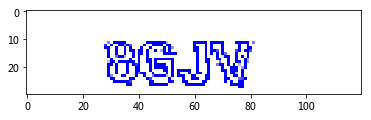

In [70]:
from requests import session
import json
import base64
import io

url = 'https://sso.toutiao.com/account_login/'
payload = {}
with session() as c:
    resp = c.post(url, data = payload)
    captcha = json.loads(resp.text)['captcha']
    #jrtt使用gif格式来保存验证码，可以打印data，以检查图像格式
    data = base64.b64decode(captcha)
    image = Image.open(io.BytesIO(data))
#     image.show()
    plt.imshow(image)
#     f = open("jrttcaptcha.gif", "wb")
#     f.write(data)
#     f.close()


# 2.构建深度神经网络

## 使用 ImageGenerator 来实时增强数据集

In [96]:
def JrttCaptchaGenerator(batch_size, path=None):
    # to determine dimensions
    # cap = captcha.JrttCaptcha()
    cap = JrttCaptcha()
    img, text = cap.get_captcha()
    shape = np.asarray(img).shape
    vocab = Vocab()
    while (1):
        X = np.empty((batch_size, shape[0], shape[1], shape[2]))
        Y = np.empty((batch_size, len(text) * vocab.size))
        for j in range(batch_size):
            img, text = cap.get_captcha()
            #img.save(path + text + ".jpg")
            X[j] = np.array(img) / 255
            Y[j] = vocab.text_to_one_hot(text)
        yield X, Y

## 神经网络

In [84]:
from keras.layers import Dense, Dropout, Activation, Flatten, Input, merge, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, Sequential
import warnings
warnings.filterwarnings('ignore')

import numpy as np
# from generator import JrttCaptchaGenerator
# from captcha import JrttCaptcha
# from vocab import Vocab

batch_size = 32
ocr_shape = (30, 120, 3) # height, width, channels
nb_classes = 62

inputs = Input(shape = ocr_shape, name = "inputs")
conv1 = Conv2D(32, (3, 3), name = "conv1")(inputs)
relu1 = Activation('relu', name="relu1")(conv1)
conv2 = Conv2D(32, (3, 3), name = "conv2")(relu1)
relu2 = Activation('relu', name="relu2")(conv2)
pool2 = MaxPooling2D(pool_size=(2,2), border_mode='same', name="pool2")(relu2)
conv3 = Conv2D(64, (3, 3), name = "conv3")(pool2)
relu3 = Activation('relu', name="relu3")(conv3)
pool3 = AveragePooling2D(pool_size=(2,2), name="pool3")(relu3)
fl = Flatten()(pool3)
fc1 = Dense(nb_classes, name="fc1")(fl)
drop = Dropout(0.25, name = "dropout1")(fc1)
fc21= Dense(nb_classes, name="fc21", activation="softmax")(drop)
fc22= Dense(nb_classes, name="fc22", activation="softmax")(drop)
fc23= Dense(nb_classes, name="fc23", activation="softmax")(drop)
fc24= Dense(nb_classes, name="fc24", activation="softmax")(drop)

merged = merge([fc21, fc22, fc23, fc24], mode = 'concat', name = "merged")
model = Model(inputs = inputs, outputs = merged)
model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 30, 120, 3)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 118, 32)  896         inputs[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 28, 118, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 26, 116, 32)  9248        relu1[0][0]                      
__________________________________________________________________________________________________
relu2 (Act

## 模型可视化
用keras中的提供的方法`plot_model`可以将模型导出成图片

`plot_model` 有以下依赖
```
brew install graphviz
pip install pydot-ng
```

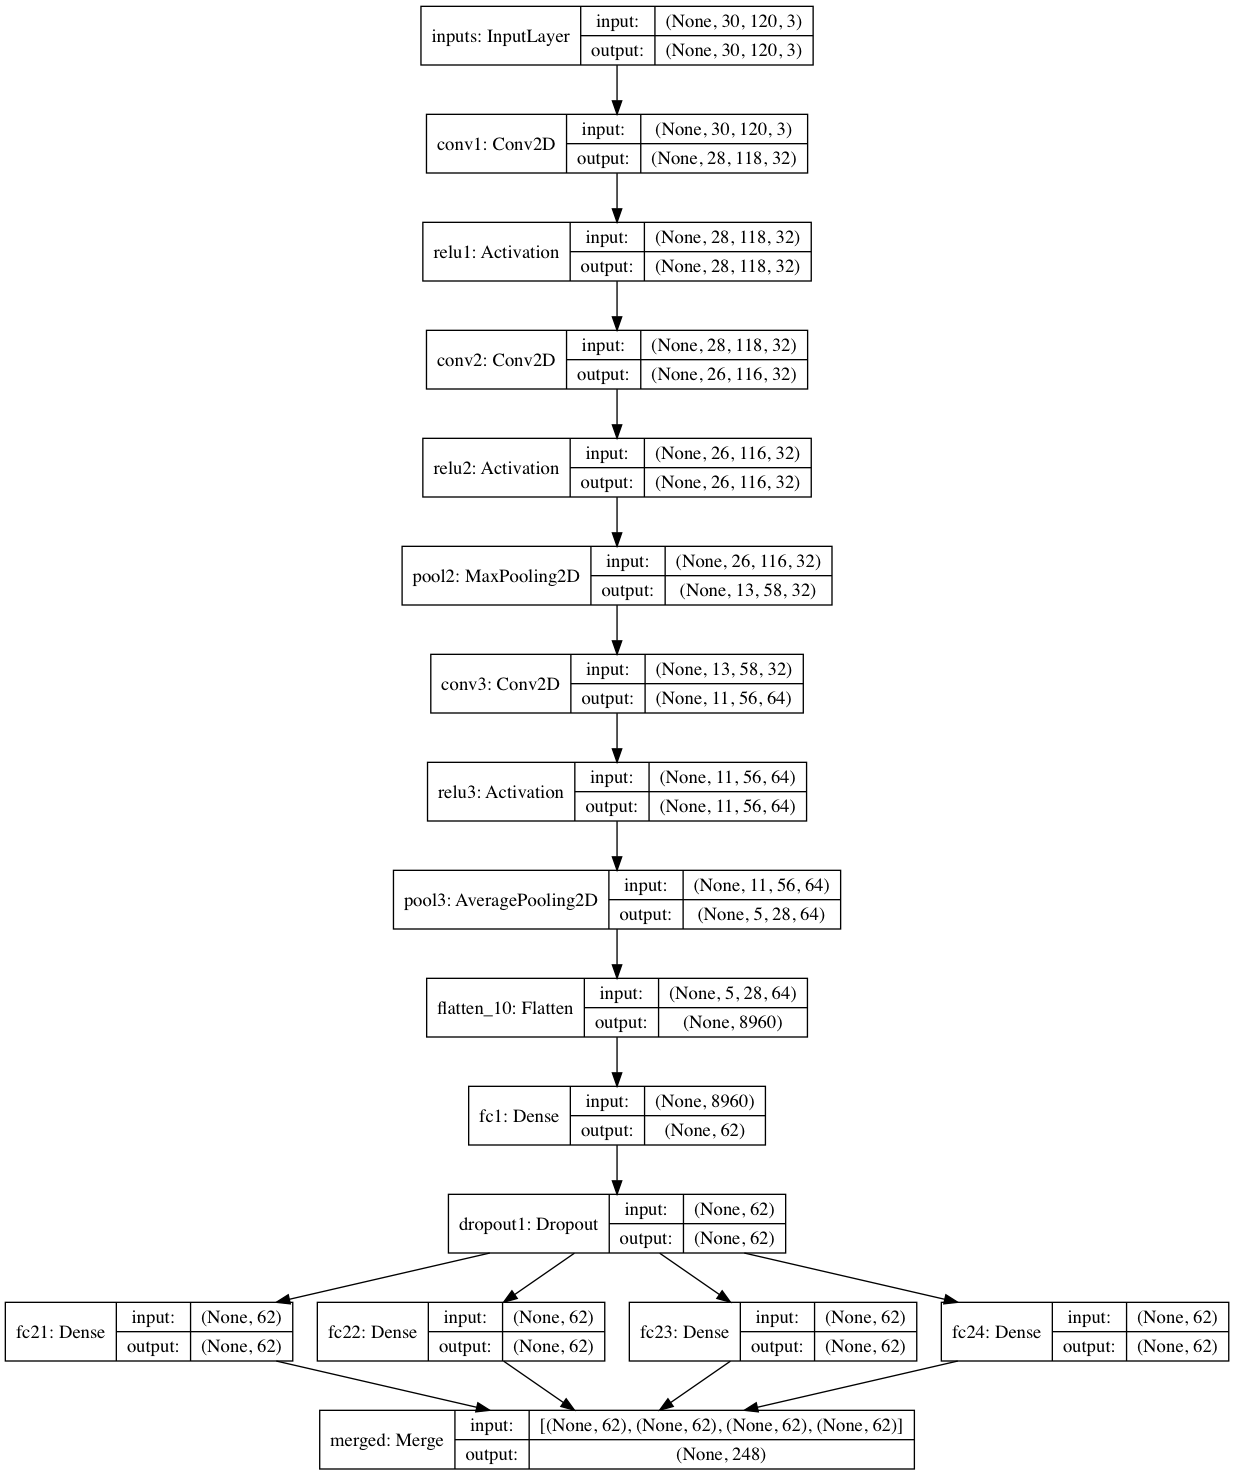

In [85]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='../data/images/captcha_cnn_model.png', show_shapes=True)
Image('../data/images/captcha_cnn_model.png')

网络的前面几层仿造了AlexNet，第一组由一个卷积层开始，再加一个relu函数定义的激活层；第二组网络则在激活层之后增加了pooling层； 第三层网络类似第二层，不过使用了AveragePooling层。这之后是一个flatten，再加上一个全连接和dropout。

比较有意思的是这之后的四个全连接层，它们全都直接连接到fc1层。使用四个分支的全连接层的主要的目的，是希望借这种结构解决多标签的分类问题。最后将四个分支的全连接的输出组合起来，通过多分类交叉熵损失函数来进行评估

In [ ]:
model.fit_generator(JrttCaptchaGenerator(batch_size, None), steps_per_epoch=1000, epochs=100)
model.save("../data/models/Jrtt_capcha_model.h5")

# 3.预测

In [17]:
from keras.models import Model, load_model

model = load_model('../data/models/Jrtt_capcha_model.h5')

('True value is ', 'CgfO')
('Prediceted value is ', 'CgfQ')
('True value is ', 'qUID')
('Prediceted value is ', 'qUJD')
Accuracy is: 0.9000


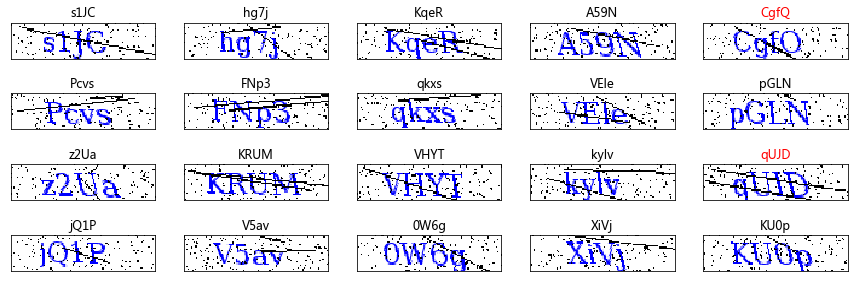

In [134]:
import math
plt.figure(figsize=(15,5))
acc = 0;
n = 20
num_per_row = 5
num_rows = math.ceil(n/float(num_per_row))

for i in range(n):
    img, text = JrttCaptcha().get_captcha()
    X = np.empty((1, 30, 120, 3))
    X[0] = np.array(img, dtype = np.uint8) / 255
    Y_pred = model.predict(X)
    Pred_text = Vocab().one_hot_to_text(Y_pred[0])
    if Pred_text == text:
        acc +=1
        
    if Pred_text != text:
        print("True value is ", text)
        print("Prediceted value is ", Pred_text)
        
    ax = plt.subplot(num_rows, num_per_row, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)
    plt_title = plt.title("%s" % Pred_text)
    if Pred_text != text:
        plt.setp(plt_title, color='r')
        
print("Accuracy is: %.4f" % (acc/float(n)))        

**预测效果还是很不错的**
在训练集上的 `accuracy`为 `40%`左右，实际测试中达到了`90%`左右, 总的来说该模型的效果还是不错的!!!

**注** 红色字体的为识别错误标注!

用该模型识别一下今日头条的验证码 (貌似是不行的)， 估计与字段有关系!

In [102]:
from requests import session
import json
import base64
import io
def get_jrtt_captcha(count=1):
    images = []
    url = 'https://sso.toutiao.com/account_login/'
    payload = {}
    with session() as c:
        
        for i in range(count):
            resp = c.post(url, data = payload)
            captcha = json.loads(resp.text)['captcha']
            #jrtt使用gif格式来保存验证码，可以打印data，以检查图像格式
            data = base64.b64decode(captcha)
            image = Image.open(io.BytesIO(data))
            image = image.convert("RGB")
#             image = Image.frombuffer(mode='RGB',size=(120,30), data=data)
#             image = image.resize((120,30),Image.ANTIALIAS)
            images.append(image)
            print image
    return images       

<PIL.Image.Image image mode=RGB size=120x30 at 0x12BC68190>


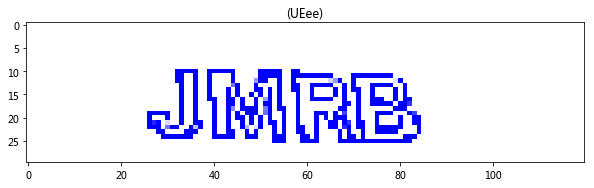

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
images_data =  get_jrtt_captcha()
for img in images_data:
    X = np.empty((1, 30, 120, 3))
    X[0] = np.array(img,  dtype = np.uint8) / 255
    predict = model.predict(X)
    pred_text = Vocab().one_hot_to_text(predict[0])
    plt.imshow(img)
    plt.title("(%s)" % pred_text)

【参考】
-  [基于卷积神经网络实现验证码识别（一）](https://hbaaron.github.io/blog_2017/%E5%9F%BA%E4%BA%8E%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%AE%9E%E7%8E%B0%E9%AA%8C%E8%AF%81%E7%A0%81%E8%AF%86%E5%88%AB%EF%BC%88%E4%B8%80%EF%BC%89/)
- [基于卷积神经网络实现验证码识别（二）](https://hbaaron.github.io/blog_2017/%E5%9F%BA%E4%BA%8E%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%AE%9E%E7%8E%B0%E9%AA%8C%E8%AF%81%E7%A0%81%E8%AF%86%E5%88%AB%EF%BC%88%E4%BA%8C%EF%BC%89/)
- [RNN 网络实战](https://github.com/907231602/RNNTest)